<a href="https://colab.research.google.com/github/kucan23/Dark-Pattern_ML/blob/main/color_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install virtualenv
!virtualenv env
!source env/bin/activate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 21.0 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 1787ms
  creator CPython3Posix(dest=/content/env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.3.1, setuptools==69.0.2, wheel==0.42.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.4/709.4 kB 4.3 MB/s eta 0:00:00


In [ ]:
import ultralytics  # Import the YOLOv8 library
import cv2  # Import OpenCV for image processing and color analysis
import json  # Import JSON for creating output objects
from sklearn.cluster import DBSCAN

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


%cd /content/drive/MyDrive/Colab Notebooks


/content/drive/MyDrive/Colab Notebooks


In [ ]:
''' to test if i am getting the right text buttons '''

# from google.colab.patches import cv2_imshow
# image = cv2.imread("IMG-20240127-WA0005.jpg")

# # Iterate through the detected text buttons and draw bounding boxes
# for text_button in text_buttons:
#     bbox = text_button["bbox"]  # Access the bounding box coordinates directly
#     x1, y1, x2, y2 = (bbox)  # Convert coordinates to integers explicitly
#     cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green rectangle
#     cv2.putText(image, text_button["class"], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)  # Class label

# # Display the image with bounding boxes
# cv2_imshow(image)
# cv2.waitKey(0)

' to test if i am getting the right text buttons '

In [ ]:
# Start new


WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
image 1/1 /content/drive/MyDrive/Colab Notebooks/pic1.jpg: 736x352 1 UpperTaskBar, 10 Icons, 3 Images, 12 Texts, 3 TextButtons, 652.9ms
Speed: 4.1ms preprocess, 652.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 352)


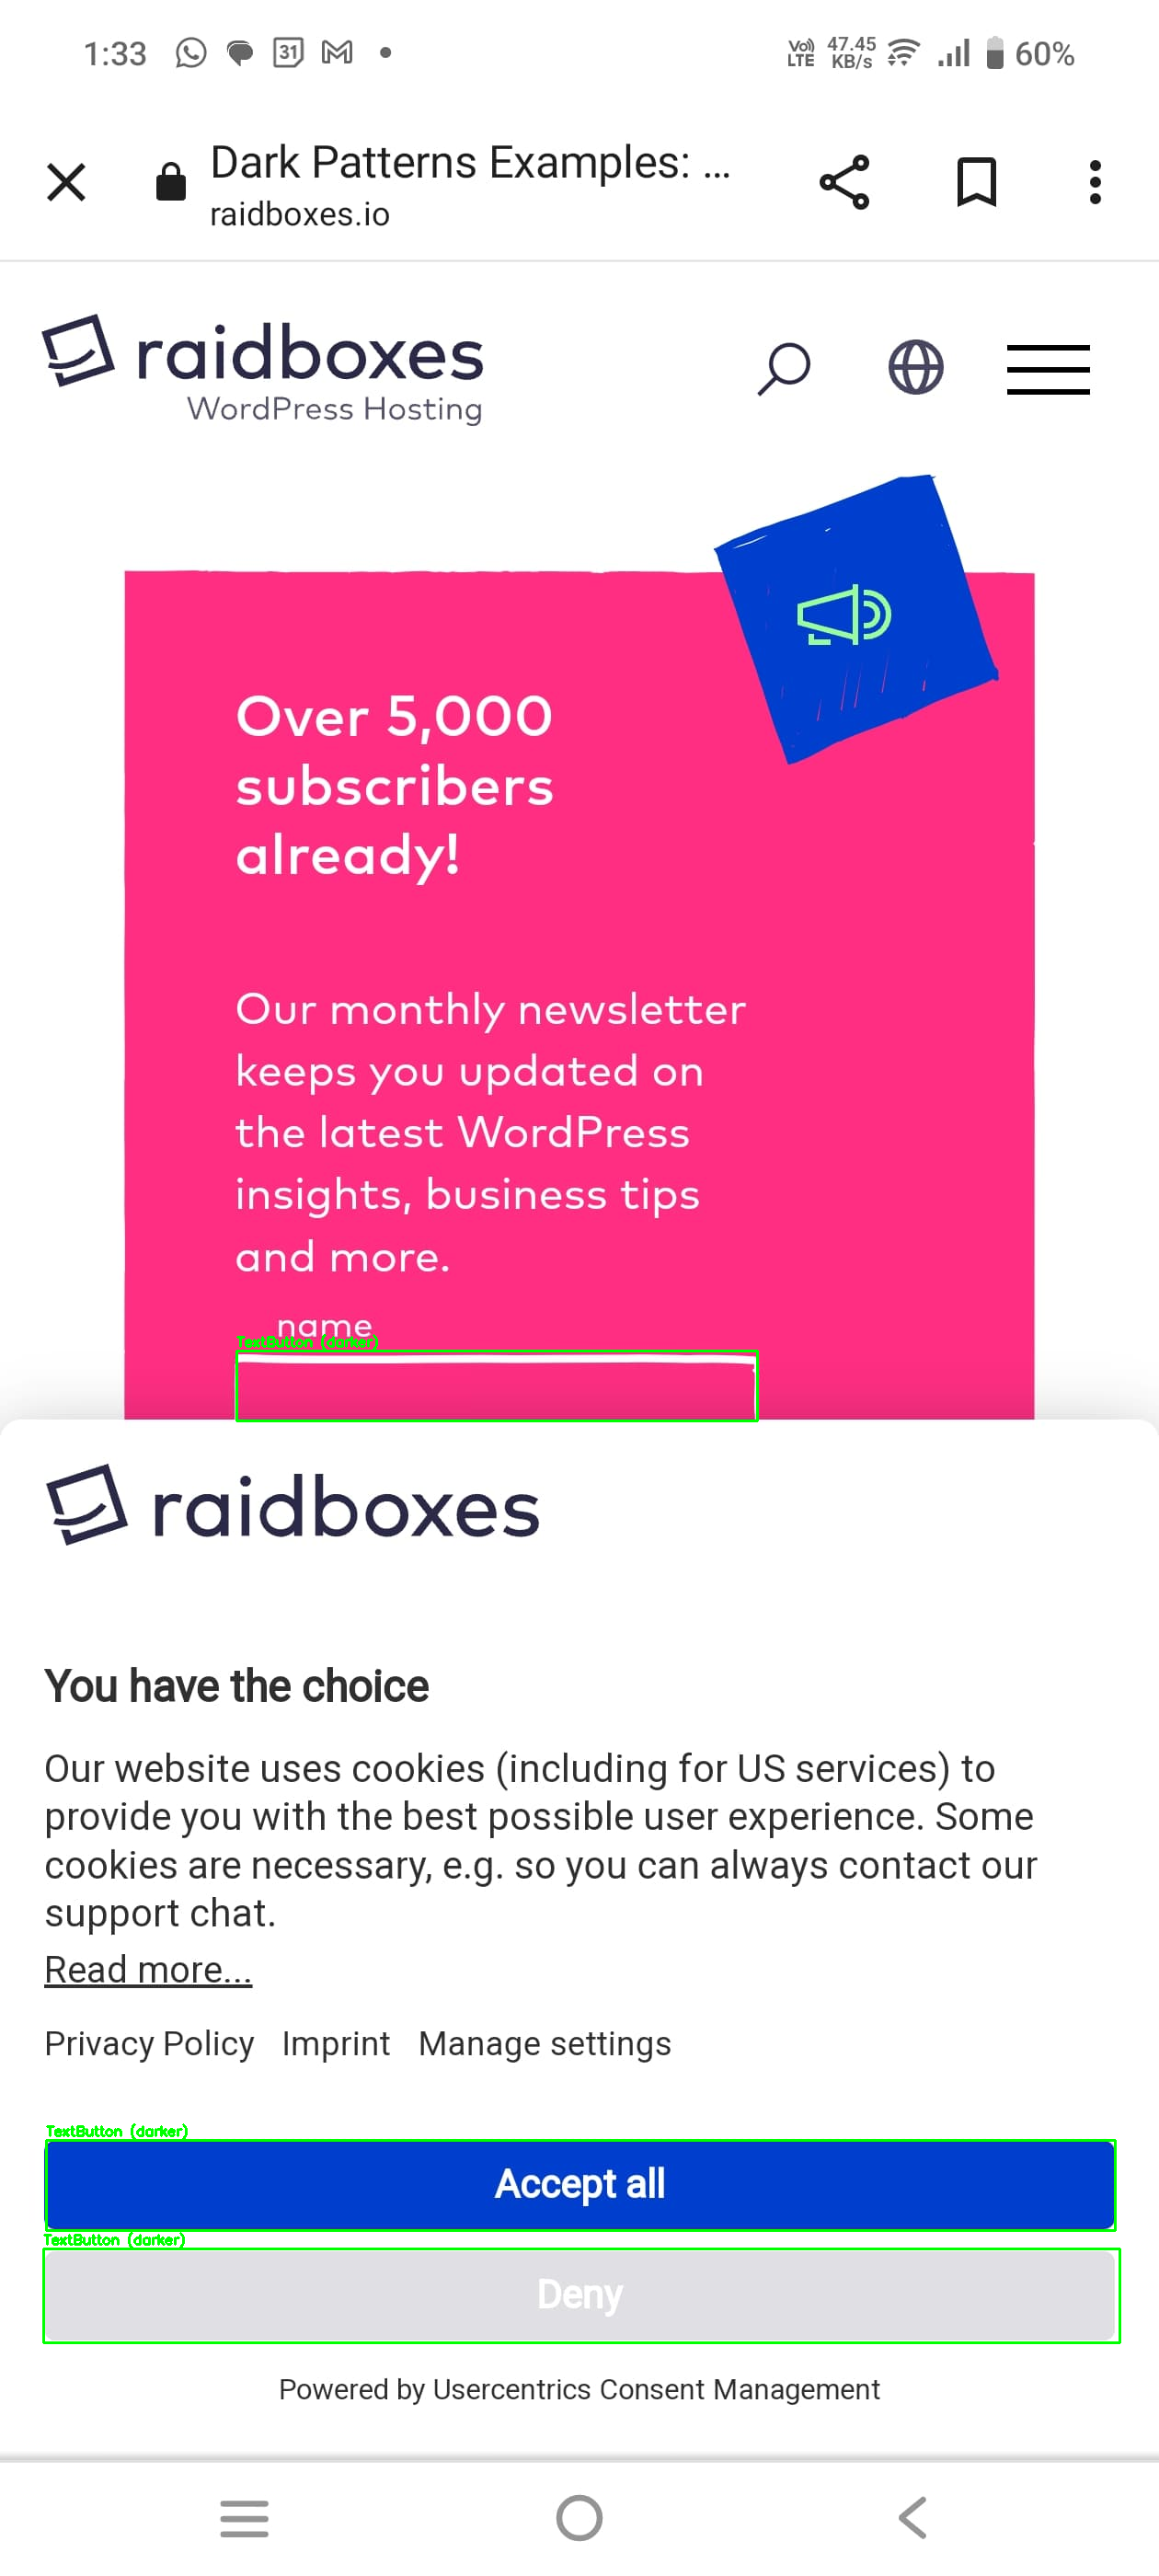

In [ ]:

def load_yolov8_model(weights_path):
    return ultralytics.YOLO(weights_path)

def detect_text_buttons(model, image_path):
    results = model.predict(source=image_path, imgsz=720, name="test")

    text_buttons = []
    for box in results[0].boxes:
        cls = int(box.cls)
        class_name = model.names[cls]
        if class_name == "TextButton":
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            text_button = {
                "class": class_name,
                "bbox": [x1, y1, x2, y2],
            }
            text_buttons.append(text_button)

    return text_buttons

def get_dominant_color(histogram):
    color_index = np.argmax(histogram)
    b, g, r = [color_index // 256, (color_index % 256) // 32, color_index % 32]
    return b, g, r

def get_contrast_color(histogram, dominant_color):
    distances = []
    for i in range(len(histogram)):
        b, g, r = [(i // 256) // 32, ((i % 256) // 32) // 32, i % 32]
        distance = np.sqrt(((b - dominant_color[0]) ** 2) + ((g - dominant_color[1]) ** 2) + ((r - dominant_color[2]) ** 2))
        distances.append(distance)
    contrasting_color_index = np.argmax(distances)
    b, g, r = [contrasting_color_index // 256, (contrasting_color_index % 256) // 32, contrasting_color_index % 32]
    return b, g, r

def calculate_luminance_ratio(button_region, background_region):

  # Convert to grayscale
  button_gray = cv2.cvtColor(button_region, cv2.COLOR_BGR2GRAY)
  background_gray = cv2.cvtColor(background_region, cv2.COLOR_BGR2GRAY)

  # Calculate average luminance
  button_luminance = np.mean(button_gray)
  background_luminance = np.mean(background_gray)

  # Compute luminance ratio
  luminance_ratio = button_luminance / background_luminance

  return luminance_ratio


def perform_color_analysis(img, text_buttons):
    text_button_data = []

    for text_button in text_buttons:
        x1, y1, x2, y2 = text_button["bbox"]
        text_button_region = img[y1:y2, x1:x2]
        button_region = image[y1:y2, x1:x2]
        background_region = image[y1 - 5:y2 + 5, x1 - 5:x2 + 5]  # Slightly larger background region for context

    # Calculate luminance ratio
        luminance_ratio = calculate_luminance_ratio(button_region, background_region)
        gray = cv2.cvtColor(text_button_region, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [2], [0, 256])

        dominant_color = get_dominant_color(hist)

        background_color = dominant_color
        candidate_colors = []

        for i in range(len(hist)):
            if i // 256 == dominant_color[0] and (i % 256) // 32 == dominant_color[1] and i % 32 == dominant_color[2]:
                continue
            b, g, r = [(i // 256) // 32, ((i % 256) // 32) // 32, i % 32]
            candidate_colors.append((b, g, r))

        contrasting_color = None
        max_distance = 0

        for color in candidate_colors:
            distance = np.sqrt(((color[0] - dominant_color[0]) ** 2) + ((color[1] - dominant_color[1]) ** 2) + ((color[2] - dominant_color[2]) ** 2))
            if distance > max_distance:
                max_distance = distance
                contrasting_color = color
            foreground_color = contrasting_color if max_distance >= 50 else None

        # foreground_color = contrasting_color
        # if max(distance) >= 50:
        #   foreground_color = contrasting_color

        # else:
        #   None
        #  '''if max_distance >= 50 else None'''

        background_brightness = (background_color[0] + background_color[1] + background_color[2]) / 3

        brightness_category = "darker" if background_brightness <= 127 else "brighter"

        output = {
            "class": text_button["class"],
            "bbox": text_button["bbox"],
            "brightness": brightness_category,
            "histogram": hist.tolist()
        }

        text_button_data.append({
            "bbox": text_button["bbox"],
            "class": text_button["class"],
            "brightness": brightness_category
        })

    return text_button_data

def visualize_results(img, text_button_data):
    overlay_image = img.copy()

    for data in text_button_data:
        x1, y1, x2, y2 = data["bbox"]
        font_color = (255, 255, 255)  # Default white

        if data["brightness"] == "darker":
            font_color = (0, 255, 0)  # Green for darker buttons
        elif data["brightness"] == "brighter":
            font_color = (0, 0, 255)  # Blue for brighter buttons

        cv2.rectangle(overlay_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green rectangle
        cv2.putText(overlay_image, data["class"] + " (" + data["brightness"] + ")", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, font_color, 2)

    cv2_imshow( overlay_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage:
model_path = "runs/detect/train/weights/best.pt"
image_path = "pic1.jpg"

# Load YOLOv8 model
yolov8_model = load_yolov8_model(model_path)

# Detect text buttons
text_buttons = detect_text_buttons(yolov8_model, image_path)

# Read image
image = cv2.imread(image_path)

# Perform color analysis on each text button
text_button_data = perform_color_analysis(image, text_buttons)

# Visualize the results
visualize_results(image, text_button_data)




In [ ]:
# !pip install colorspacious
# !pip install colormath
# !pip install deltae2000




In [ ]:
# from deltae2000 import delta_e_cie2000
# from colormath.color_conversions import convert_color
# # from colormath.color_objects import sRGBColor, LabColor


ModuleNotFoundError: No module named 'deltae2000'

In [ ]:
# def load_yolov8_model(weights_path):
#     return ultralytics.YOLO(weights_path)

# def detect_text_buttons(model, image_path):
#     results = model.predict(source=image_path, imgsz=720, name="test")

#     text_buttons = []
#     for box in results[0].boxes:
#         cls = int(box.cls)
#         class_name = model.names[cls]
#         if class_name == "TextButton":
#             x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
#             text_button = {
#                 "class": class_name,
#                 "bbox": [x1, y1, x2, y2],
#             }
#             text_buttons.append(text_button)

#     return text_buttons

# import cv2
# import numpy as np
# from colormath.color_diff import delta_e_cie2000
# from colormath.color_objects import sRGBColor, LabColor
# from scipy.spatial import distance

# def get_dominant_color(histogram):
#     color_index = np.argmax(histogram)
#     b, g, r = [color_index // 256, (color_index % 256) // 32, color_index % 32]
#     return b, g, r

# def get_contrast_color(hist, dominant_color):
#     # Exclude dominant color bin
#     hist[dominant_color[0] * 32 * 32 + dominant_color[1] * 32 + dominant_color[2]] = 0

#     contrasting_color_index = np.argmax(hist)
#     b, g, r = [contrasting_color_index // (32 * 32), (contrasting_color_index % (32 * 32)) // 32, contrasting_color_index % 32]
#     return b, g, r

# def calculate_ciede2000_color_difference(color1, color2):
#     # Convert colors to CIELab
#     lab_color1 = cspace_convert(color1, start={"name": "sRGB"}, end={"name": "CIELab"})
#     lab_color2 = cspace_convert(color2, start={"name": "sRGB"}, end={"name": "CIELab"})

#     # Calculate CIEDE2000 color difference
#     delta_e = distance.cdist([lab_color1], [lab_color2], 'euclidean')[0][0]
#     return delta_e

# def perform_color_analysis(img, text_buttons):
#     text_button_data = []

#     for text_button in text_buttons:
#         x1, y1, x2, y2 = text_button["bbox"]
#         text_button_region = img[y1:y2, x1:x2]
#         gray = cv2.cvtColor(text_button_region, cv2.COLOR_BGR2GRAY)
#         hist = cv2.calcHist([gray], [0], None, [2], [0, 256])

#         dominant_color = get_dominant_color(hist)

#         background_color = dominant_color

#         # Calculate contrast color directly from the histogram
#         contrasting_color = get_contrast_color(hist.flatten(), dominant_color)

#         foreground_color = contrasting_color if calculate_ciede2000_color_difference(contrasting_color, dominant_color) >= 50 else None
#         background_brightness = (background_color[0] + background_color[1] + background_color[2]) / 3

#         brightness_category = "darker" if background_brightness <= 127 else "brighter"

#         output = {
#             "class": text_button["class"],
#             "bbox": text_button["bbox"],
#             "brightness": brightness_category,
#             "histogram": hist.tolist()
#         }

#         text_button_data.append({
#             "bbox": text_button["bbox"],
#             "class": text_button["class"],
#             "brightness": brightness_category
#         })

#     return text_button_data


# def visualize_results(img, text_button_data):
#     overlay_image = img.copy()

#     for data in text_button_data:
#         x1, y1, x2, y2 = data["bbox"]
#         font_color = (255, 255, 255)  # Default white

#         if data["brightness"] == "darker":
#             font_color = (0, 255, 0)  # Green for darker buttons
#         elif data["brightness"] == "brighter":
#             font_color = (0, 0, 255)  # Blue for brighter buttons

#         cv2.rectangle(overlay_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green rectangle
#         cv2.putText(overlay_image, data["class"] + " (" + data["brightness"] + ")", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, font_color, 2)

#     cv2_imshow( overlay_image)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

# # Example usage:
# model_path = "runs/detect/train/weights/best.pt"
# image_path = "An-example-of-interface-interference-aesthetic-manipulation-shared-by-an-author.png"

# # Load YOLOv8 model
# yolov8_model = load_yolov8_model(model_path)

# # Detect text buttons
# text_buttons = detect_text_buttons(yolov8_model, image_path)

# # Read image
# image = cv2.imread(image_path)

# # Perform color analysis on each text button
# text_button_data = perform_color_analysis(image, text_buttons)

# # Visualize the results
# visualize_results(image, text_button_data)


WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
image 1/1 /content/drive/MyDrive/Colab Notebooks/pic1.jpg: 736x352 1 UpperTaskBar, 10 Icons, 3 Images, 12 Texts, 3 TextButtons, 344.7ms
Speed: 2.8ms preprocess, 344.7ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 352)


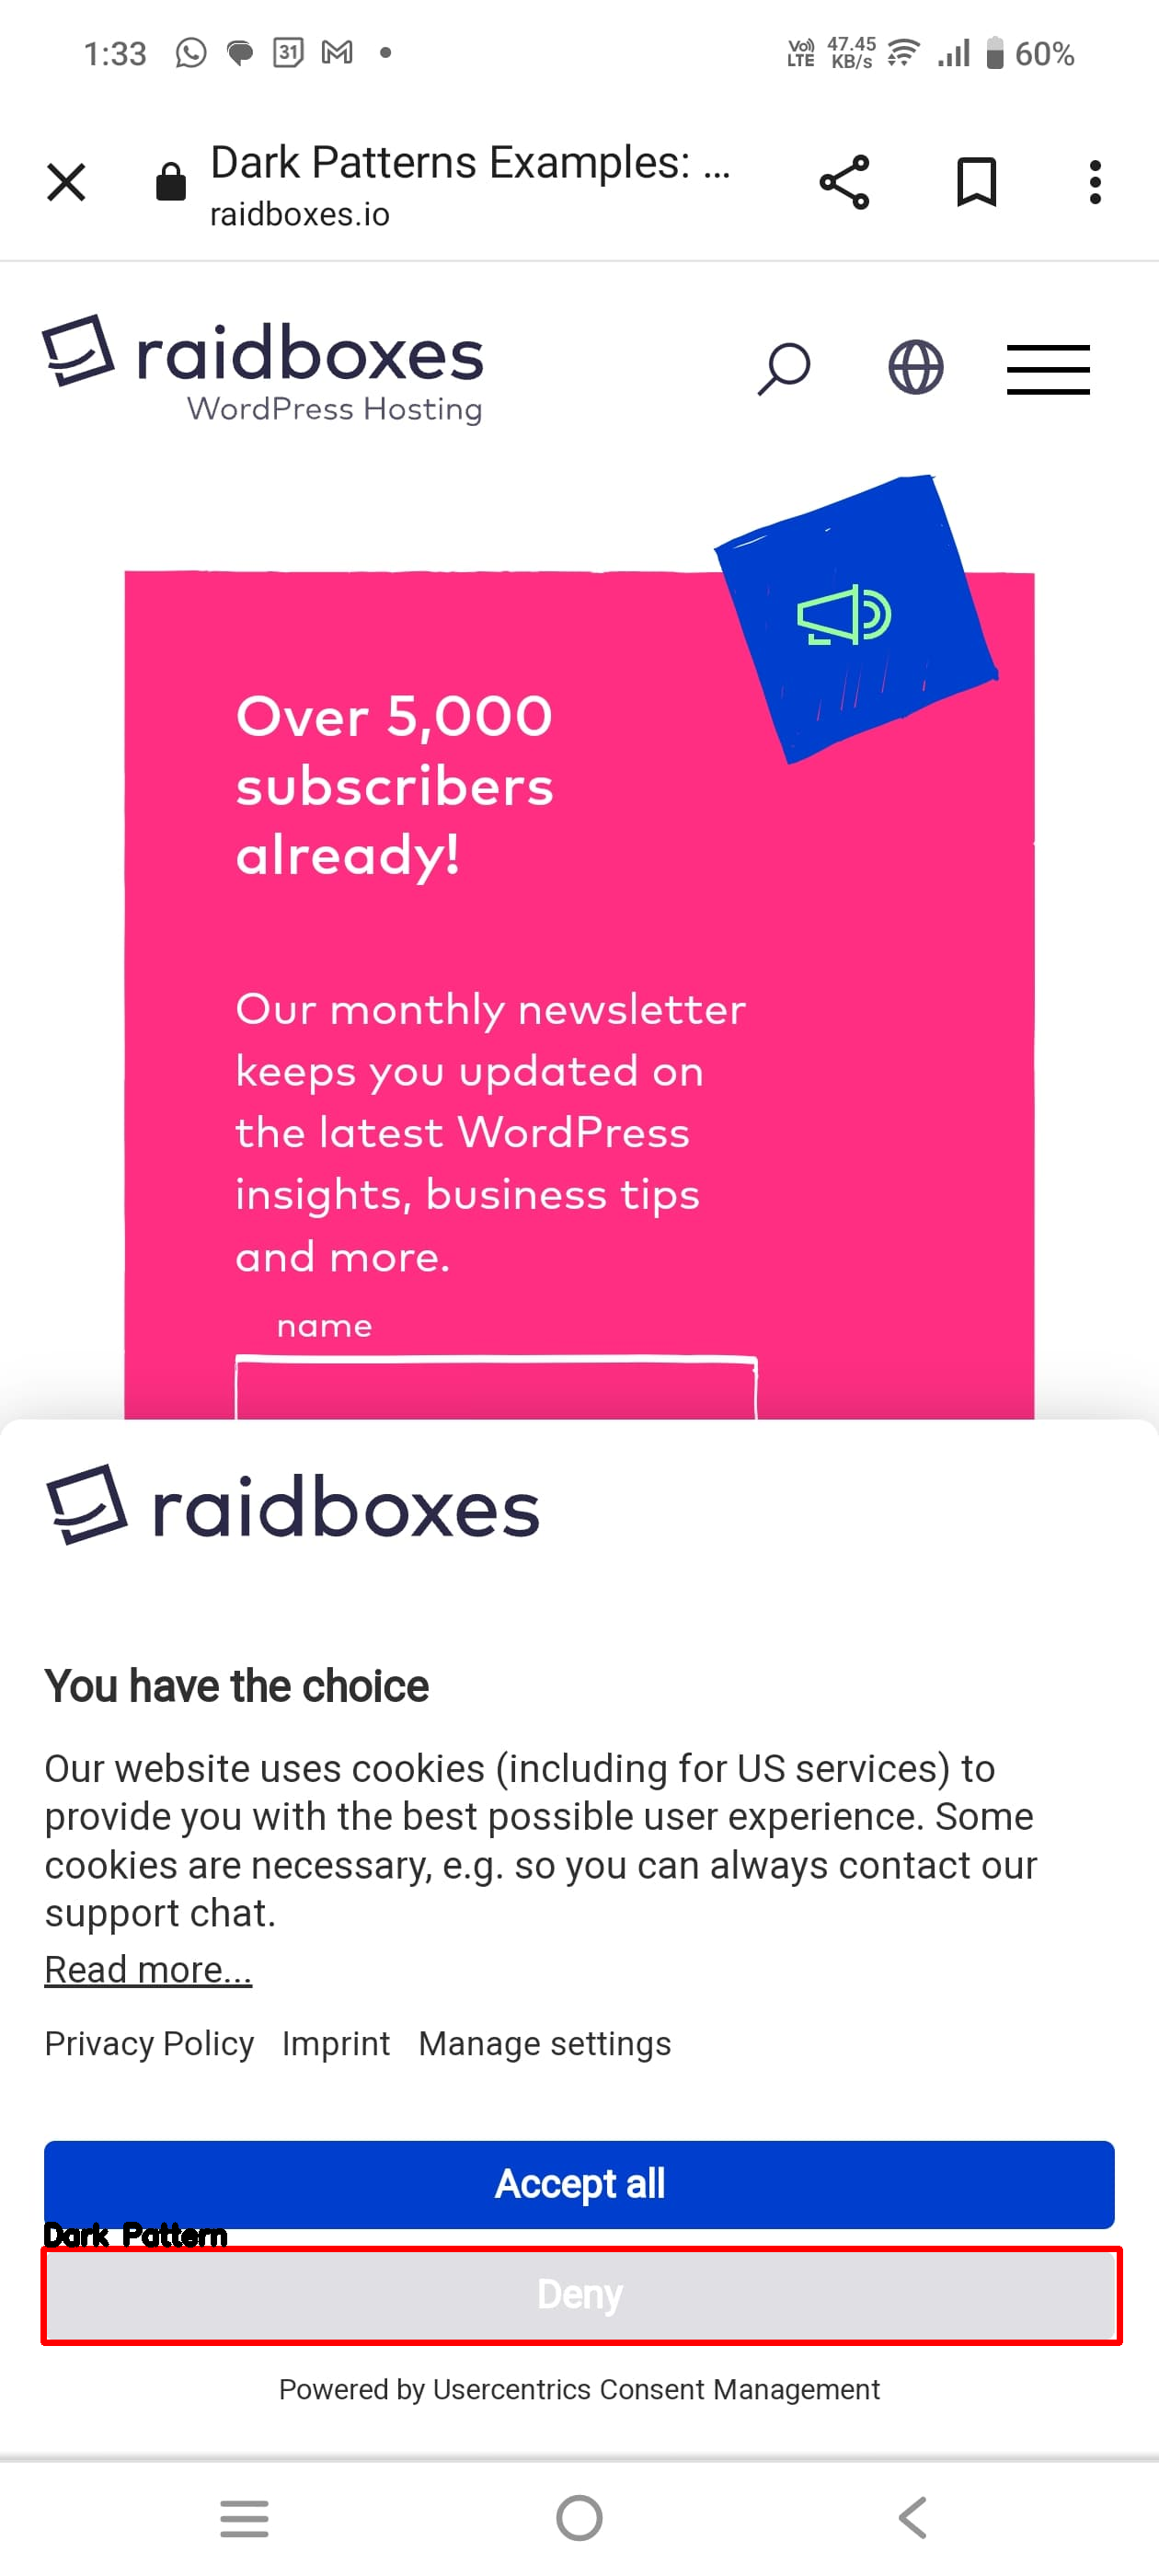

In [ ]:

def load_yolov8_model(weights_path):
  return ultralytics.YOLO(weights_path)


def calculate_histogram(image, coordinates):
  # Extract region based on coordinates
  img = image[coordinates[0]:coordinates[1], coordinates[2]:coordinates[3]]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  hist = cv2.calcHist([img], [0], None, [2], [0, 256])
  return hist

def detect_text_buttons(model, image_path):
    results = model.predict(source=image_path, imgsz=720, name="test")

    text_buttons = []
    for box in results[0].boxes:
        cls = int(box.cls)
        class_name = model.names[cls]
        if class_name == "TextButton":
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            text_button = {
                "class": class_name,
                "bbox": [x1, y1, x2, y2],
            }
            text_buttons.append(text_button)

    return text_buttons

def calculate_luminance_ratio(button_region, background_region):

  button_gray = cv2.cvtColor(button_region, cv2.COLOR_BGR2GRAY)
  background_gray = cv2.cvtColor(background_region, cv2.COLOR_BGR2GRAY)

  button_luminance = np.mean(button_gray)
  background_luminance = np.mean(background_gray)

  luminance_ratio = button_luminance / background_luminance

  return luminance_ratio


def get_opacity(hist):
  hist /= hist.sum()
  if hist[0][0] > .65:
    return "darker"
  elif hist[1][0] > .65:
    return "brighter"
  else:
    return "normal"

def perform_color_analysis(img, text_buttons):
  text_button_data = []

  for text_button in text_buttons:
    x1, y1, x2, y2 = text_button["bbox"]
    button_region = img[y1:y2, x1:x2]
    background_region = img[y1 - 5:y2 + 5, x1 - 5:x2 + 5]
    luminance_ratio = calculate_luminance_ratio(button_region, background_region)

    hist = calculate_histogram(img, (y1, y2, x1, x2))
    opacity = get_opacity(hist)

    brightness_category = "darker" if opacity == "darker" else "brighter"

    output = {
      "class": text_button["class"],
      "bbox": text_button["bbox"],
      "brightness": brightness_category,
      "luminance_ratio": luminance_ratio,
      "histogram": hist.tolist()
    }

    text_button_data.append(output)

  return text_button_data

def visualize_results(img, text_button_data):
    overlay_image = img.copy()

    for data in text_button_data:
        x1, y1, x2, y2 = data["bbox"]
        font_color = (255, 255, 255)

        if data["brightness"] == "darker":
            font_color = (0, 255, 0)
            # font_color = (0, 0, 255)
        elif data["brightness"] == "brighter":
            font_color = (0, 0, 255)
            # font_color = (0, 255, 0)

        # cv2.rectangle(overlay_image, (x1, y1), (x2, y2), (0, 255, 0), 5)
        # cv2.putText(overlay_image, data["class"], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, font_color, 2)
        # rectangle_color = (0, 255, 0)  # Default green

        if data["brightness"] == "brighter":
          text_label = "Dark Pattern"
          cv2.rectangle(overlay_image, (x1, y1), (x2, y2), (0, 0, 255), 5)
          cv2.putText(overlay_image, text_label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 5)  # Black text

          # rectangle_color =   # Red for brighter buttons


    cv2_imshow( overlay_image)
    cv2.imwrite("color1.jpg", overlay_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

model_path = "runs/detect/train/weights/best.pt"
image_path = "pic1.jpg"

yolov8_model = load_yolov8_model(model_path)

text_buttons = detect_text_buttons(yolov8_model, image_path)

image = cv2.imread(image_path)
text_button_data = perform_color_analysis(image, text_buttons)
visualize_results(image, text_button_data)


